In [1]:
!pip install dowhy econml
!apt-get install -y graphviz-dev graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.9/301.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.9/172.9 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 41.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Succ

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
pkg-config is already the newest version (0.29.1-0ubuntu4).
graphviz is already the newest version (2.42.2-3build2).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 15 not upgraded.
Need to get 2,148 kB of archives.
After this operation, 7,427 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libgtk2.0-common all 2.24.32-4ubuntu4 [126 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libgtk2.0-0 amd64 2.24.32-4ubuntu4 [1,791 kB]
Get:3 http

Restart runtime now ;)

In [ ]:
import random
import os
import dowhy
import pygraphviz
import numpy as np
import pandas as pd
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter
import logging
import warnings
from sklearn.exceptions import DataConversionWarning
from IPython.display import Image, display

In [68]:
# Avoiding unnecessary log messges and warnings
logging.getLogger("dowhy").setLevel(logging.WARNING)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Define the number of farms and the number of time periods to simulate
n_farms = 10 # also indicates number of cows in a farm
n_periods = 365

# Define the treatment and outcome variables
treatment_variable_name = 'treatment'
outcome_variable_name = 'milk_outcome'
farm_id = np.repeat(range(n_farms), n_periods)

# Generate random data for the farms and time periods
treatment_assignments = farm_id * np.array([random.choice([0, 2]) for _ in range(n_periods*n_farms)])  # Assign treatments to farms
outcome_noises = np.random.normal(0, 0.1 , n_periods*n_farms)  # Generate outcome noise
outcomes = 10*(1+farm_id) + 3*treatment_assignments + outcome_noises  # Calculate outcomes

data = pd.DataFrame({
    'farm_id' : farm_id,
    'treatment': treatment_assignments,
    'milk_outcome': outcomes
})
# Save the data to a CSV file
data.to_csv('milk_production_data.csv', index=False)

# **The four steps of causal inference**

## I. Modeling

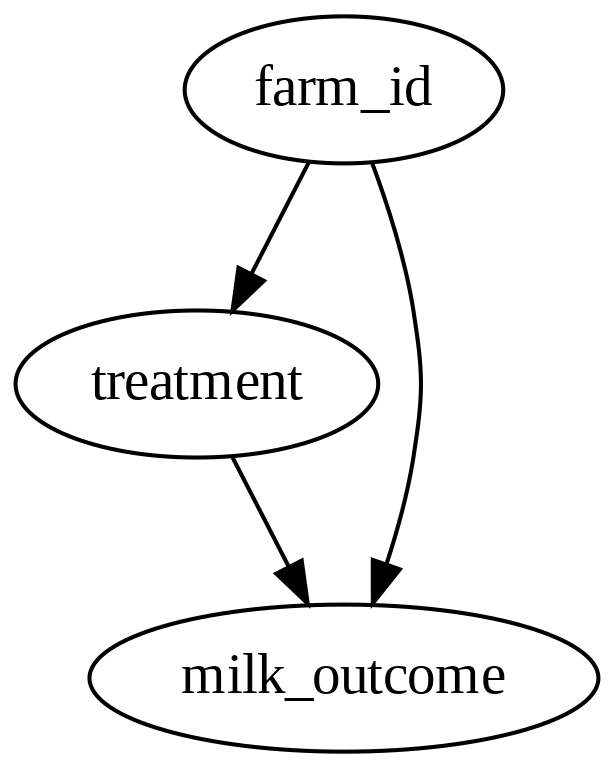

In [70]:
model = CausalModel(
    data=data,
    treatment=treatment_variable_name,
    outcome=outcome_variable_name,
    graph='causal_graph.dot'
)

model.view_model(layout="dot")
display(Image(filename="causal_model.png"))

## II. Identify causal effect and return target estimands


In [71]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(E[milk_outcome|farm_id])
d[treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→milk_outcome then P(milk_outcome|treatment,farm_id,U) = P(milk_outcome|treatment,farm_id)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## III. Estimate the target estimand using a statistical method.


In [72]:
linear_regression_estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")

print(linear_regression_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(E[milk_outcome|farm_id])
d[treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→milk_outcome then P(milk_outcome|treatment,farm_id,U) = P(milk_outcome|treatment,farm_id)

## Realized estimand
b: milk_outcome~treatment+farm_id
Target units: ate

## Estimate
Mean value: 2.9998944332679542



Causal Estimate is 2.9998944332679542


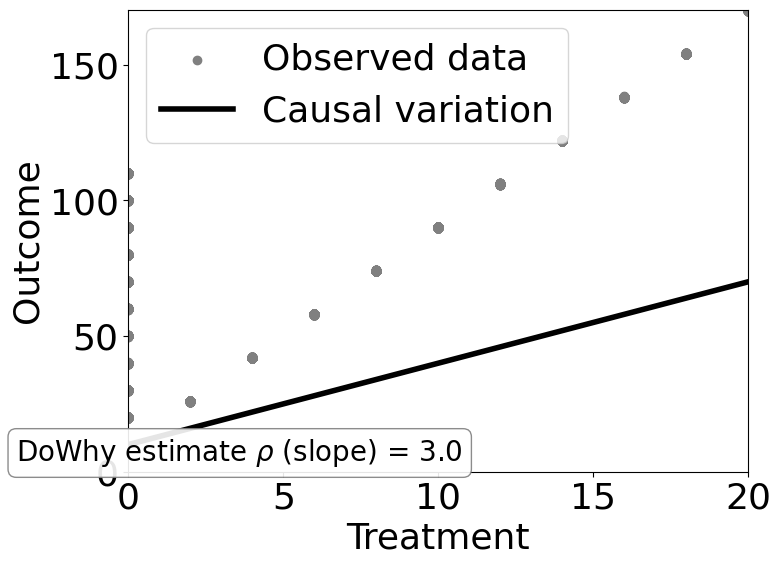

In [73]:
print("Causal Estimate is " + str(linear_regression_estimate.value))
# Plot Slope of line between action and outcome = causal effect
dowhy.plotter.plot_causal_effect(linear_regression_estimate, data["treatment"], data["milk_outcome"])

## IV. Refute the obtained estimate using multiple robustness checks.


In [74]:
# Replacing treatment with a random (placebo) variable
linear_regression_refute_results = model.refute_estimate(identified_estimand, linear_regression_estimate,
                                       method_name="placebo_treatment_refuter")
print(linear_regression_refute_results)

Refute: Use a Placebo Treatment
Estimated effect:2.9998944332679542
New effect:-0.0075700010549036275
p value:0.8400000000000001



In [75]:
# Adding a random common cause variable
res_random=model.refute_estimate(identified_estimand, linear_regression_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:2.9998944332679542
New effect:2.999894283526463
p value:1.0



In [76]:
# Removing a random subset of the data
res_subset=model.refute_estimate(identified_estimand, linear_regression_estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:2.9998944332679542
New effect:2.999874732873955
p value:0.74



**Note**: For a refutation test, the p-value denotes whether the test has found a problem with the estimate. If p-value <0.05, this means that the estimate has a problem. If not, then we cannot conclude anything. Since all p-values are >0.05, it means that all tests are unable to find a problem in the estimate.

**EconML** implements a powerful set of estimators that use machine learning.

We show an example of using Propensity Score Stratification using a machine learning-based method called **Double-ML** using EconML.

In [77]:
import econml
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand,
                                    method_name="backdoor.econml.dml.DML",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),
                                                        'model_final':LassoCV(fit_intercept=False), },
                                        'fit_params': {}
                                     })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(E[milk_outcome|farm_id])
d[treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→milk_outcome then P(milk_outcome|treatment,farm_id,U) = P(milk_outcome|treatment,farm_id)

## Realized estimand
b: milk_outcome~treatment+farm_id | 
Target units: ate

## Estimate
Mean value: 2.99687368203912
Effect estimates: [[2.99687368]]



In [78]:
# Replacing treatment with a random (placebo) variable
linear_regression_refute_results = model.refute_estimate(identified_estimand, dml_estimate,
                                       method_name="placebo_treatment_refuter")
print(linear_regression_refute_results)
# Adding a random common cause variable
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)
# Removing a random subset of the data
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a Placebo Treatment
Estimated effect:2.99687368203912
New effect:0.006939483362168627
p value:1.54

Refute: Add a random common cause
Estimated effect:2.99687368203912
New effect:2.984933123861063
p value:0.0

Refute: Use a subset of data
Estimated effect:2.99687368203912
New effect:2.996883844733679
p value:0.88

